In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pydmd.bopdmd import BOPDMD
from scipy.signal import lsim
import pickle
import seaborn as sns
from scipy.io import loadmat

In [2]:
def bopdmd_train_test(
    svd_rank, num_trials, training_set, training_voltage, test_voltage, train_time,
    test_time, Btilde, return_training_fit, conjugate_bool, stable_bool, noise_level, evaluate, C, D
):
    """
    Perform the BOPDMD using the PyDMD library package. Optionally enforce stability of the 
    DMD modes, complex-conjugate pairs, training and test evaluation of the model.
    
    Args:
        svd_rank, integer
          number of DMD modes to use in the decomposition.
        num_trials, integer
          Number of BOPDMD fits to make.
        training_set
          Training data for fitting the BOPDMD modes.
        training_voltage
          Training control input for evaluating the DMD fit to the training data.
        test_voltage
          Test control input for evaluating the DMD fit to the testing data.
        train_time
          Training time base for fitting the BOPDMD modes.
        test_time
          Time base for testing the BOPDMD modes.
        Btilde
          B matrix appearing in the xdot = Ax + Bu equation. 
        return_training_fit, bool
          Boolean flag to evaluate the DMD fit to the training data.
        conjugate_bool, bool
          Boolean flag to use BOPDMD only with complex-conjugate pairs.
        stable_bool, bool
          Boolean flag to use BOPDMD only with stable eigenvalues.
        noise_level, float
          Percentage of noise to use from 0 to 100 percent. 
        evaluate, bool
          Boolean flag to evaluate the BOPDMD model on testing data.
        C, 2D numpy array
          Matrix appearing in ydot = Cx + Du.
        D, 2D numpy array
          Matrix appearing in ydot = Cx + Du.
    """
    # make our opt and bop objects with the correct number of trials and svd rank
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) 
        
    # Decide if we want to enforce that the models have eigenvalues that come in complex conjugate pairs
    # and enforce stability
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
    training_set_func = training_set + np.random.normal(
        0, (np.sqrt(np.mean(training_set ** 2)) / 100.0) * noise_level, training_set.shape
    )
    bopdmd.fit(training_set_func, train_time)  # fit out data
    
    Atilde = bopdmd.A  # get A matrix from bop
    
    # now we are going to see how well bop does on our test voltages. These will simulate a vacuum shot and
    # be a series of 3 state square waves that are fed into each of the four circuits
    if evaluate:
        tout, yout, xout = lsim((Atilde, Btilde, C, D), test_voltage, test_time)
        return Atilde, bopdmd, xout
    else:
        return Atilde, bopdmd
    
    if return_training_fit:
        tout_train, yout_train, xout_train = lsim((Atilde, Btilde, C, D), training_voltage, time)
        return xout_train

In [3]:
def make_graph(data, title, legend, impulse, time): 
    """
    Makes a fancy plot of the 12 state space variables vs time. 
    
    Args: 
        data, list 
            Should be a list of what one wants plotted, title is a string.
        legend, array of strings
            The legend labels for the data.
        impulse, boolean
            Flag iif one is plotting the ringdown of a shot.
    """
    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey = 'row', figsize=(20, 15))
    fig.tight_layout()
    fig.text(0.5, -0.04, 'Time (ms)', ha='center', fontsize = 20)
    fig.text(-0.04, 0.175, 'Flux Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.5, 'Capacitor Voltage (V)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.825, 'Series Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(.5,1.04,title,ha = 'center',fontsize = 40)
    
    if not impulse:
        plt.xlim([0, 4])

    L1 = [0,3,6,9]
    C = [1,4,7,10]
    L2 = [2,5,8,11]
    
    colors = ['r','k','--g']
    alphas = [1,.65,1]
    for i in range(len(L1)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+1)
            plt.plot(1000*time,np.real(j[:,L1[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()


    for i in range(len(C)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+5)
            plt.plot(1000*time,np.real(j[:,C[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()

    for i in range(len(L2)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+9)
            plt.plot(1000 * time,np.real(j[:,L2[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()
    fig.legend(legend, fontsize=15)

In [4]:
def load_vacuum_shot(directory): 
    """
    Pass in a directory as a string, and this function will cycle through the whole directory 
    
    Args:
        directory, string
          Name of the directory to find all the files in.
    """
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))
            
    input_list = []
    state_list = []
 
    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) # reshape the time vector to a 0d array

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
    state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:
        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v

        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))

    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list, inputs_list, state_deriv_list, experiment_time

In [5]:
# Load in a vacuum shot so we can use a realistic initial conditioon
# for our vacuum and plasma models
directory = "data/vacuum_shots_220816/good_shots"
trajectory_list, inputs_list, state_deriv_list, experiment_time = load_vacuum_shot(directory)

/var/folders/kk/vfzyhbbx0rv1p32zd7s42s180000gn/T/ipykernel_19848/3187382441.py:4: DeprecationWarning: Please use `StateSpaceContinuous` from the `scipy.signal` namespace, the `scipy.signal.ltisys` namespace is deprecated.
  sysc = pickle.load(file)


object successfully saved to data/continuous_vacuum_ss_model


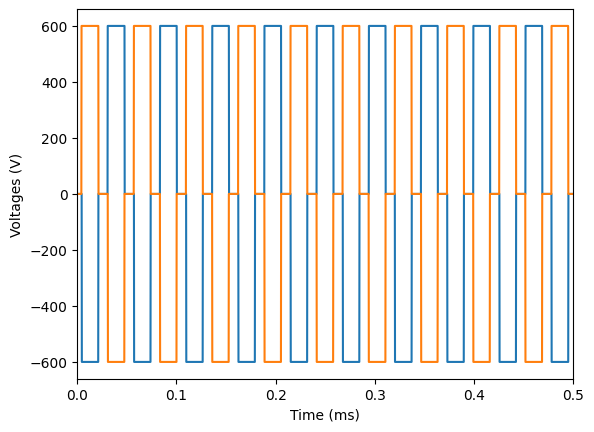

In [6]:
# Load in matrices for vacuum model of Xdot = AX + BU, Y = CX + DU
filename = 'data/continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D

# Load in matrices for plasma model of Xdot = AX + BU, Y = CX + DU
A_plasma = loadmat('data/plasma_ss_A_matrix').get('A')
B_plasma = np.vstack((B,np.zeros((1,4))))
C_plasma = np.hstack((C,np.zeros((4,1))))

# Load in control inputs U
data = loadmat('data/voltages.mat')
voltage1 = data['newVoltage']
voltage2 = data['newVoltageShift1']
voltage3 = data['newVoltageShift2']
voltage4 = data['newVoltageShift3']
time = np.linspace(0,.004,len(voltage1))

# Plot some of the voltages to verify square waves with a phase shift
plt.plot(time * 1e3, voltage1)
plt.plot(time * 1e3, voltage3)
plt.xlim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltages (V)')
plt.show()

In [7]:
# Check if A_vacuum and A_plasma are correctly negative definite
print(np.linalg.eigvals(A))
print(np.linalg.eigvals(A_plasma))

# Check that A_vacuum is basically the same as A_plasma 
# except the one new eigenvalue from the +1 dimension of A_plasma
inds = range(13)
inds = np.delete(inds, 4)
print((np.sort(np.linalg.eigvals(A)) - np.sort(np.linalg.eigvals(A_plasma)[inds]
                                             )) / np.real(np.sort(np.linalg.eigvals(A))))

[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626724 +137273.04651636j -6044.9626724 -137273.04651636j
 -6044.96265484+137273.04655166j -6044.96265484-137273.04655166j
 -2052.57854051     +0.j         -2915.80444687     +0.j
 -2915.80453607     +0.j         -2983.64806906     +0.j        ]
[ -5365.24185942+128311.09214227j  -5365.24185942-128311.09214227j
  -6164.51182327+138653.06449623j  -6164.51182327-138653.06449623j
 -12217.769524       +0.j          -6044.96266362+137273.04653401j
  -6044.96266362-137273.04653401j  -6044.96266362+137273.04653401j
  -6044.96266362-137273.04653401j  -1983.16938827     +0.j
  -3043.64370228     +0.j          -2915.80449147     +0.j
  -2915.80449147     +0.j        ]
[-2.19682788e-03+9.72446949e-05j -2.19682788e-03-9.72446949e-05j
  1.45273846e-09-2.91914907e-09j  1.45273846e-09+2.91914907e-09j
 -1.45277608e-09+2.91930796e-09j -1.45277608e-09-2.91930796e-09j
 

In [8]:
# Form the U matrix of control inputs
inputs = np.hstack((voltage1, voltage2, voltage3, voltage4))

# We want the 1 millisecond of ringdown where the SPA isn't firing, 
# so I'm going to make the last quarter of the voltage waveforms 0
inputs[30000::,:] = 0

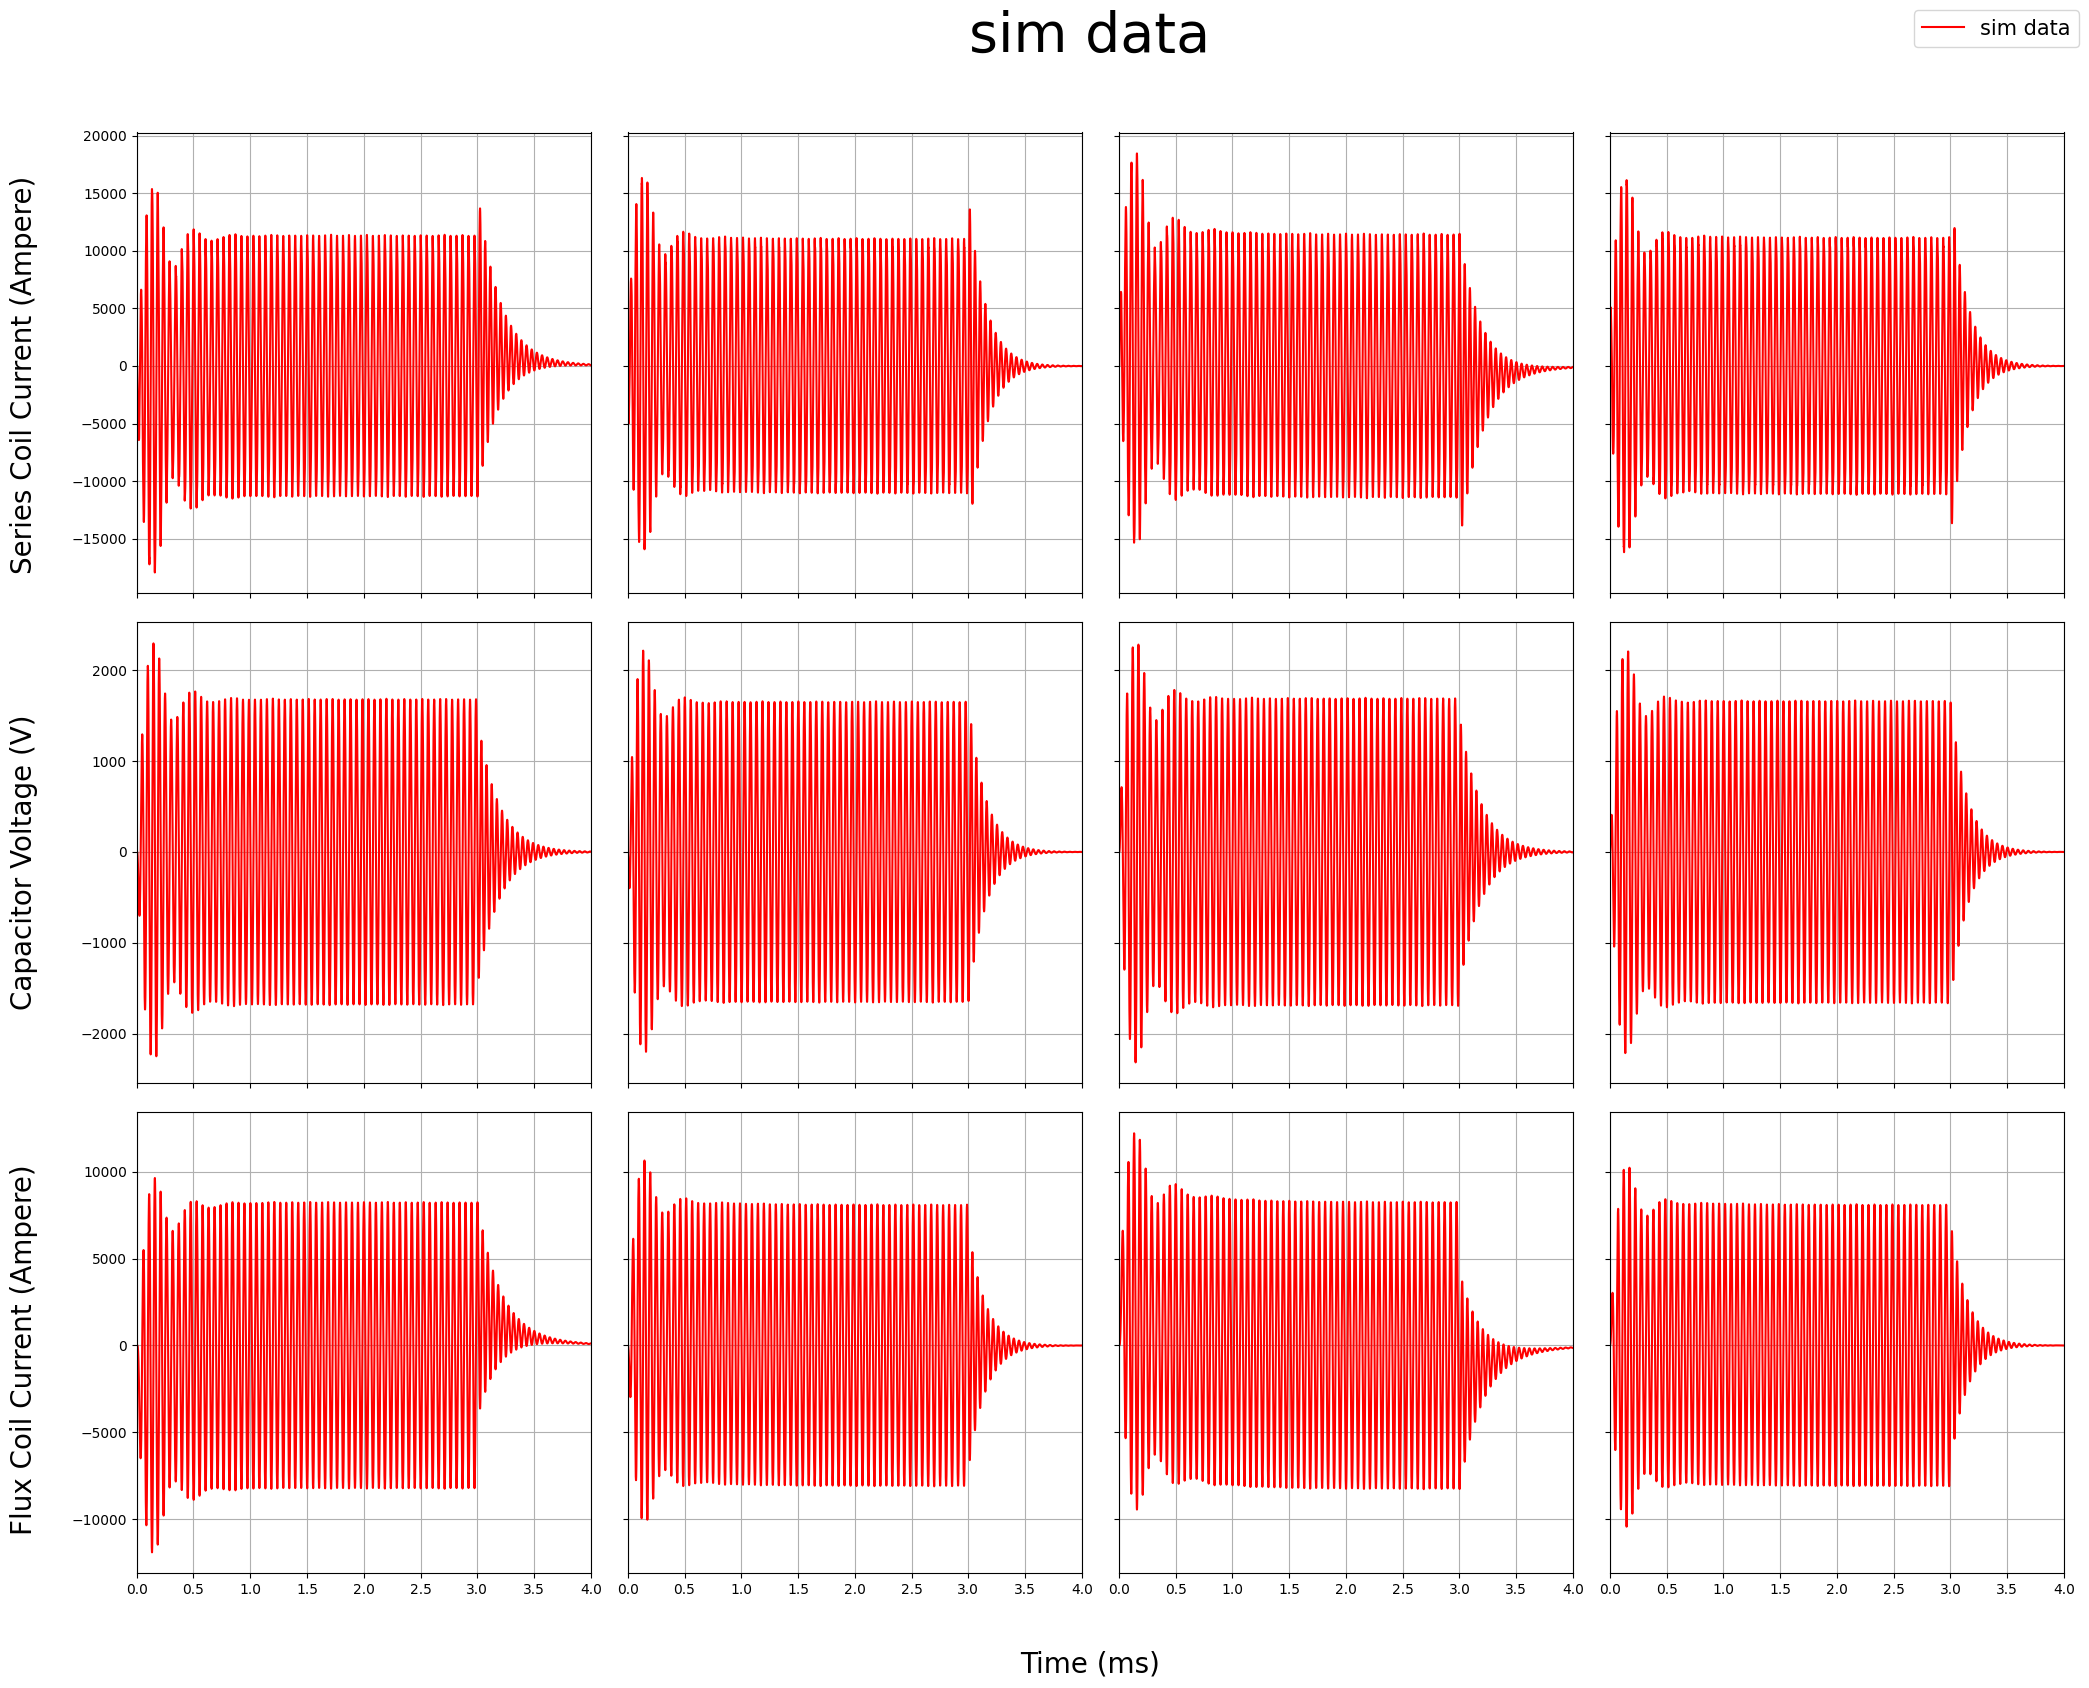

In [9]:
# Simulate the vacuum model with the chopped U matrix
tout, yout, xout_vacuum = lsim((A, B, C, D), inputs, time)
make_graph([xout_vacuum], 'sim data', ['sim data'], impulse=False, time=time)

## BOP-DMD on clean simulated data
We will compute the BOPDMD using num_trials fits of optimized DMD, constraining the fits to only product complex conjugate pairs and stable eigenvalues. If need be, the data can be downsampled with the skip parameter. 

In [10]:
Atilde_vacuum_list = []
bop_vacuum_obj_list = []
xout_vacuum_list = []
skip = 2
for i in [11]:
    [Atilde, bop_obj, xout] = bopdmd_train_test(
        svd_rank=i + 1,
        num_trials=1,
        training_set=xout_vacuum.real[30000::skip, :].T,  # this is the 'impulse' response from above
        training_voltage=inputs[30000::skip, :],
        test_voltage=inputs,
        train_time=time[30000::skip],
        test_time=time,
        Btilde=B,
        C=C,
        D=D,
        return_training_fit=False,
        conjugate_bool=True, 
        stable_bool=True,
        noise_level=0,
        evaluate = True
    )
    Atilde_vacuum_list.append(Atilde)
    bop_vacuum_obj_list.append(bop_obj)
    xout_vacuum_list.append(xout)

/Users/alankaptanoglu/anaconda3/envs/pysindy_docs/lib/python3.9/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 5082532.275758502. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/Users/alankaptanoglu/anaconda3/envs/pysindy_docs/lib/python3.9/site-packages/pydmd/bopdmd.py:557: RuntimeWarning: invalid value encountered in scalar divide
  improvement_ratio = actual_improvement / pred_improvement


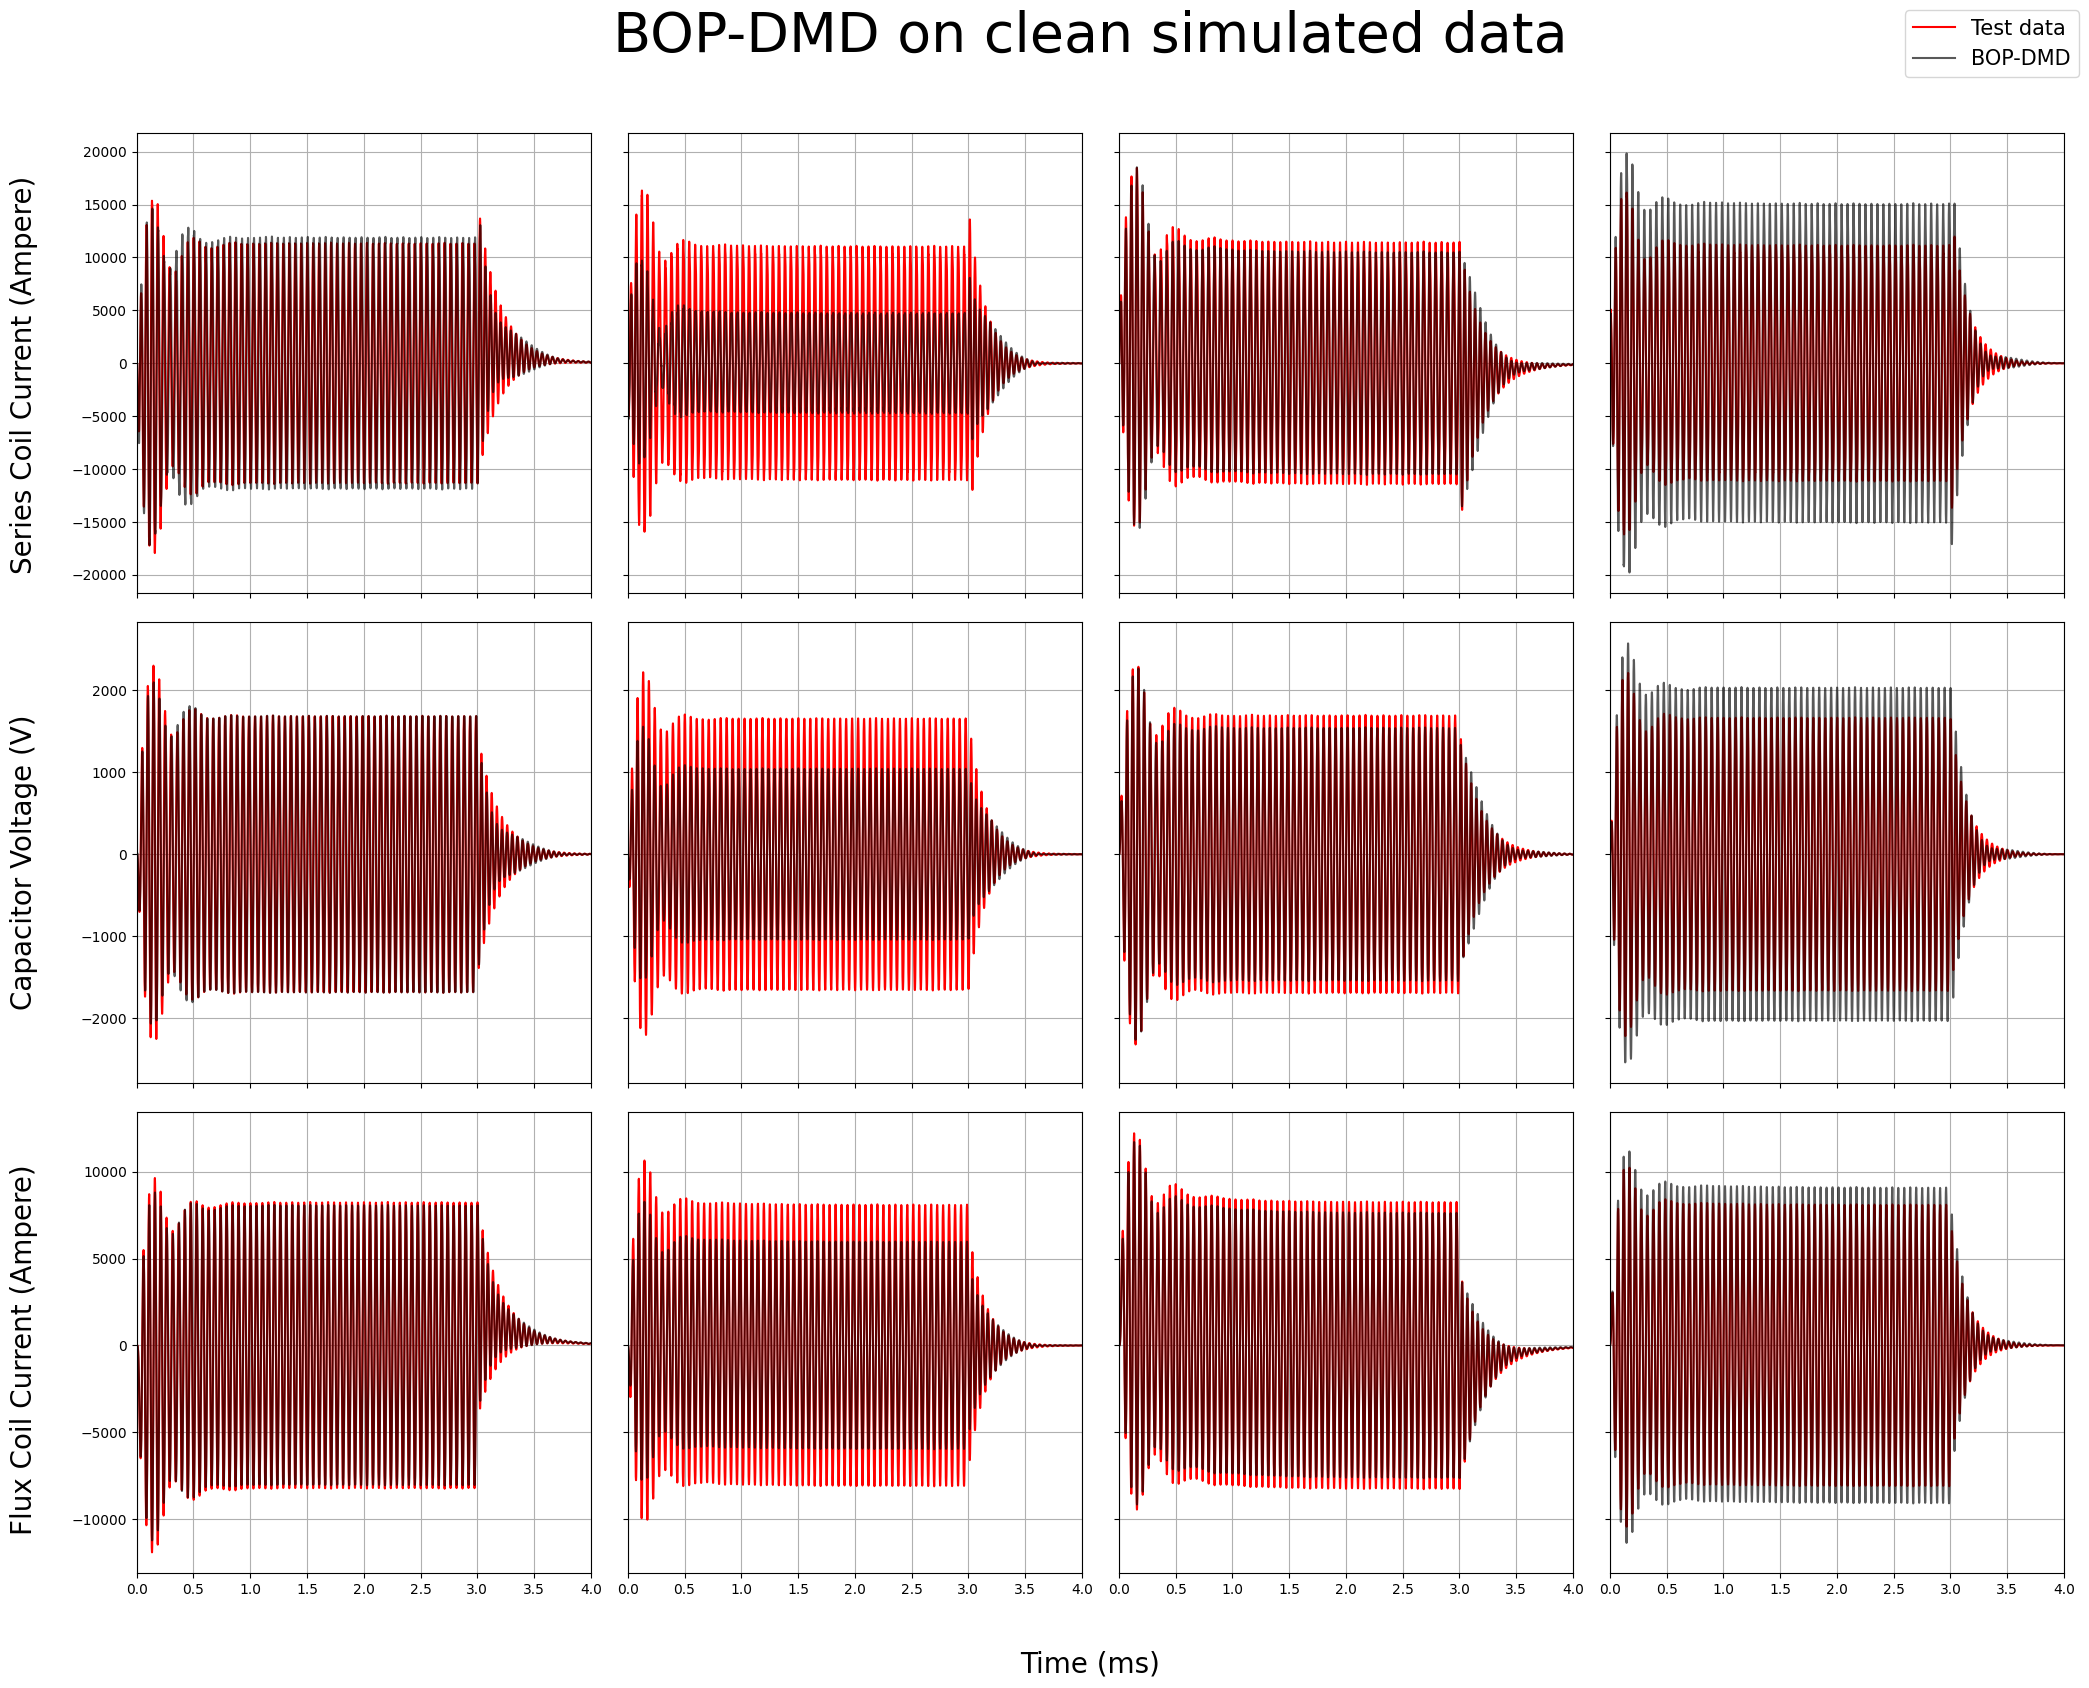

In [ ]:
# Visualize the performance of the BOP-DMD reconstruction on test data
num = 0
make_graph(
    [xout_vacuum, xout_vacuum_list[num]],
    'BOP-DMD on clean simulated data',
    ['Test data', 'BOP-DMD'],
    impulse=False,
    time=time
)

## BOPDMD captures the clean simulated data from the vacuum model
Now we compare the values of the A matrices to make sure all looks good. Indeed it does!

/var/folders/kk/vfzyhbbx0rv1p32zd7s42s180000gn/T/ipykernel_19848/2229843750.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


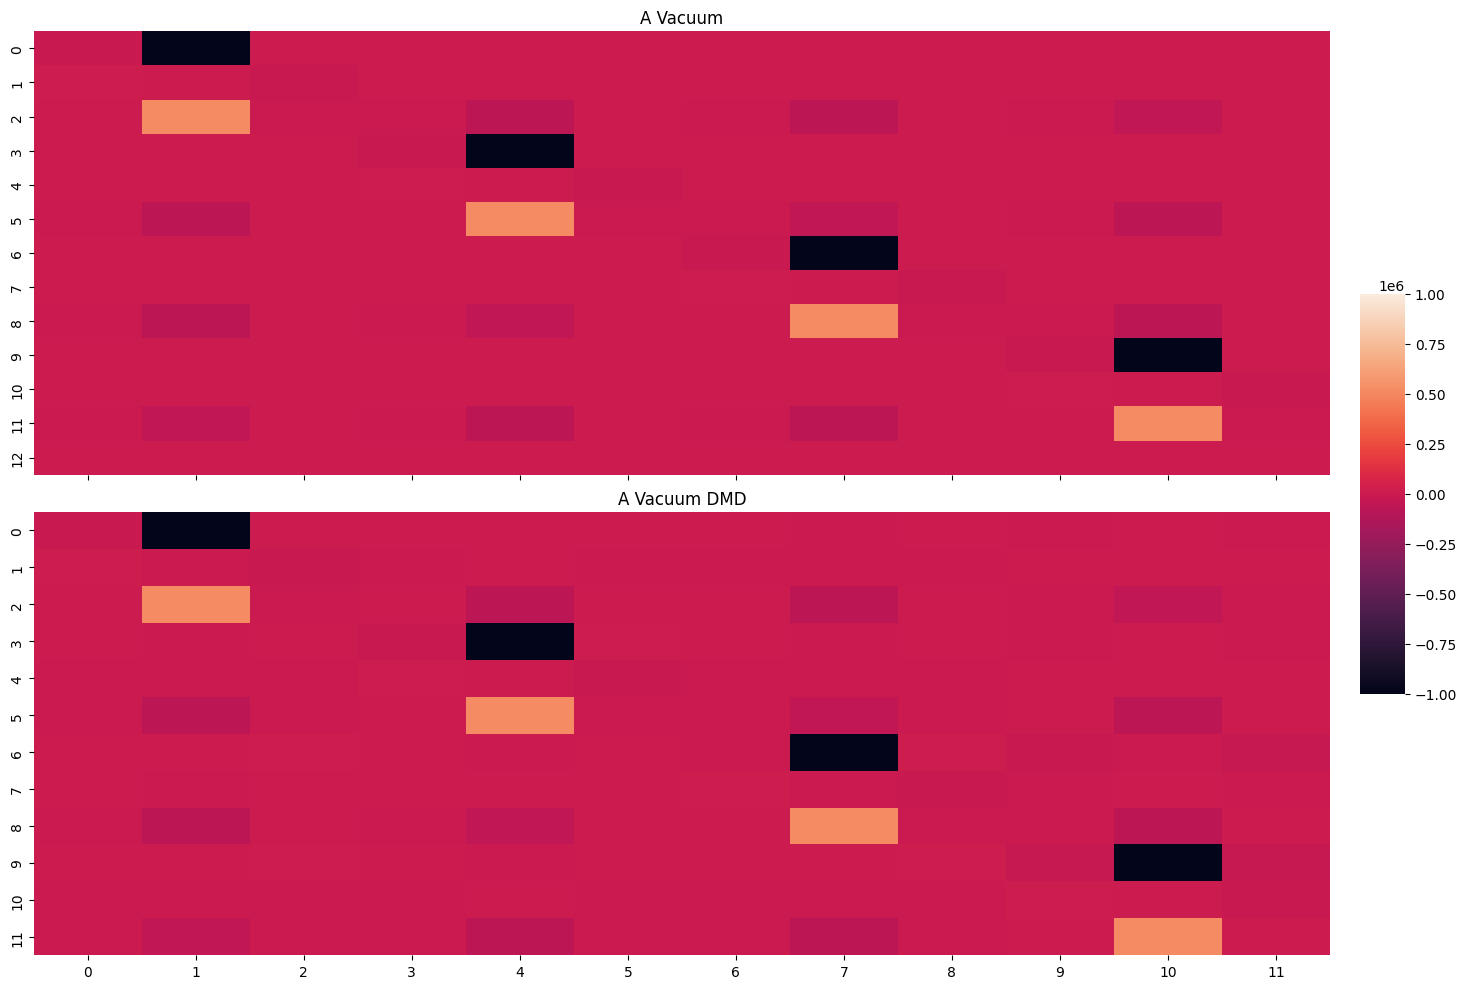

In [12]:
A_aug = np.zeros((13, 13))
A_aug[0:12,0:12] = A
vals = [A_aug, Atilde_vacuum_list[num].real]
fig, axn = plt.subplots(2, 1,figsize = (15,10),sharex = True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
titles = ['A Vacuum','A Vacuum DMD']
for i, ax in enumerate(axn.flat):
    sns.heatmap(data = vals[i], ax=ax,
                cbar=i == 0,
                cbar_ax=None if i else cbar_ax,vmin = -1e6, vmax = 1e6)
    ax.title.set_text(titles[i])
    sns.color_palette("Dark2", as_cmap=True)
fig.tight_layout(rect=[0, 0, .9, 1])

### Let's repeat with finite control inputs, before was fitting only to the U(t) = 0 region only.
This doesn't work because BOPDMD doesn't know about the BU matrix in the $$\dot{X} = AX + BU$$ equation! This equation is in the form:
$$\frac{dX}{dt} - AX(t) = BU(t),$$
which can be solved with "integrating factors" method. The solution is 
$$X(t) = e^{At}\left(X(0) + \int_0^te^{-At'}BU(t')dt'\right)$$.

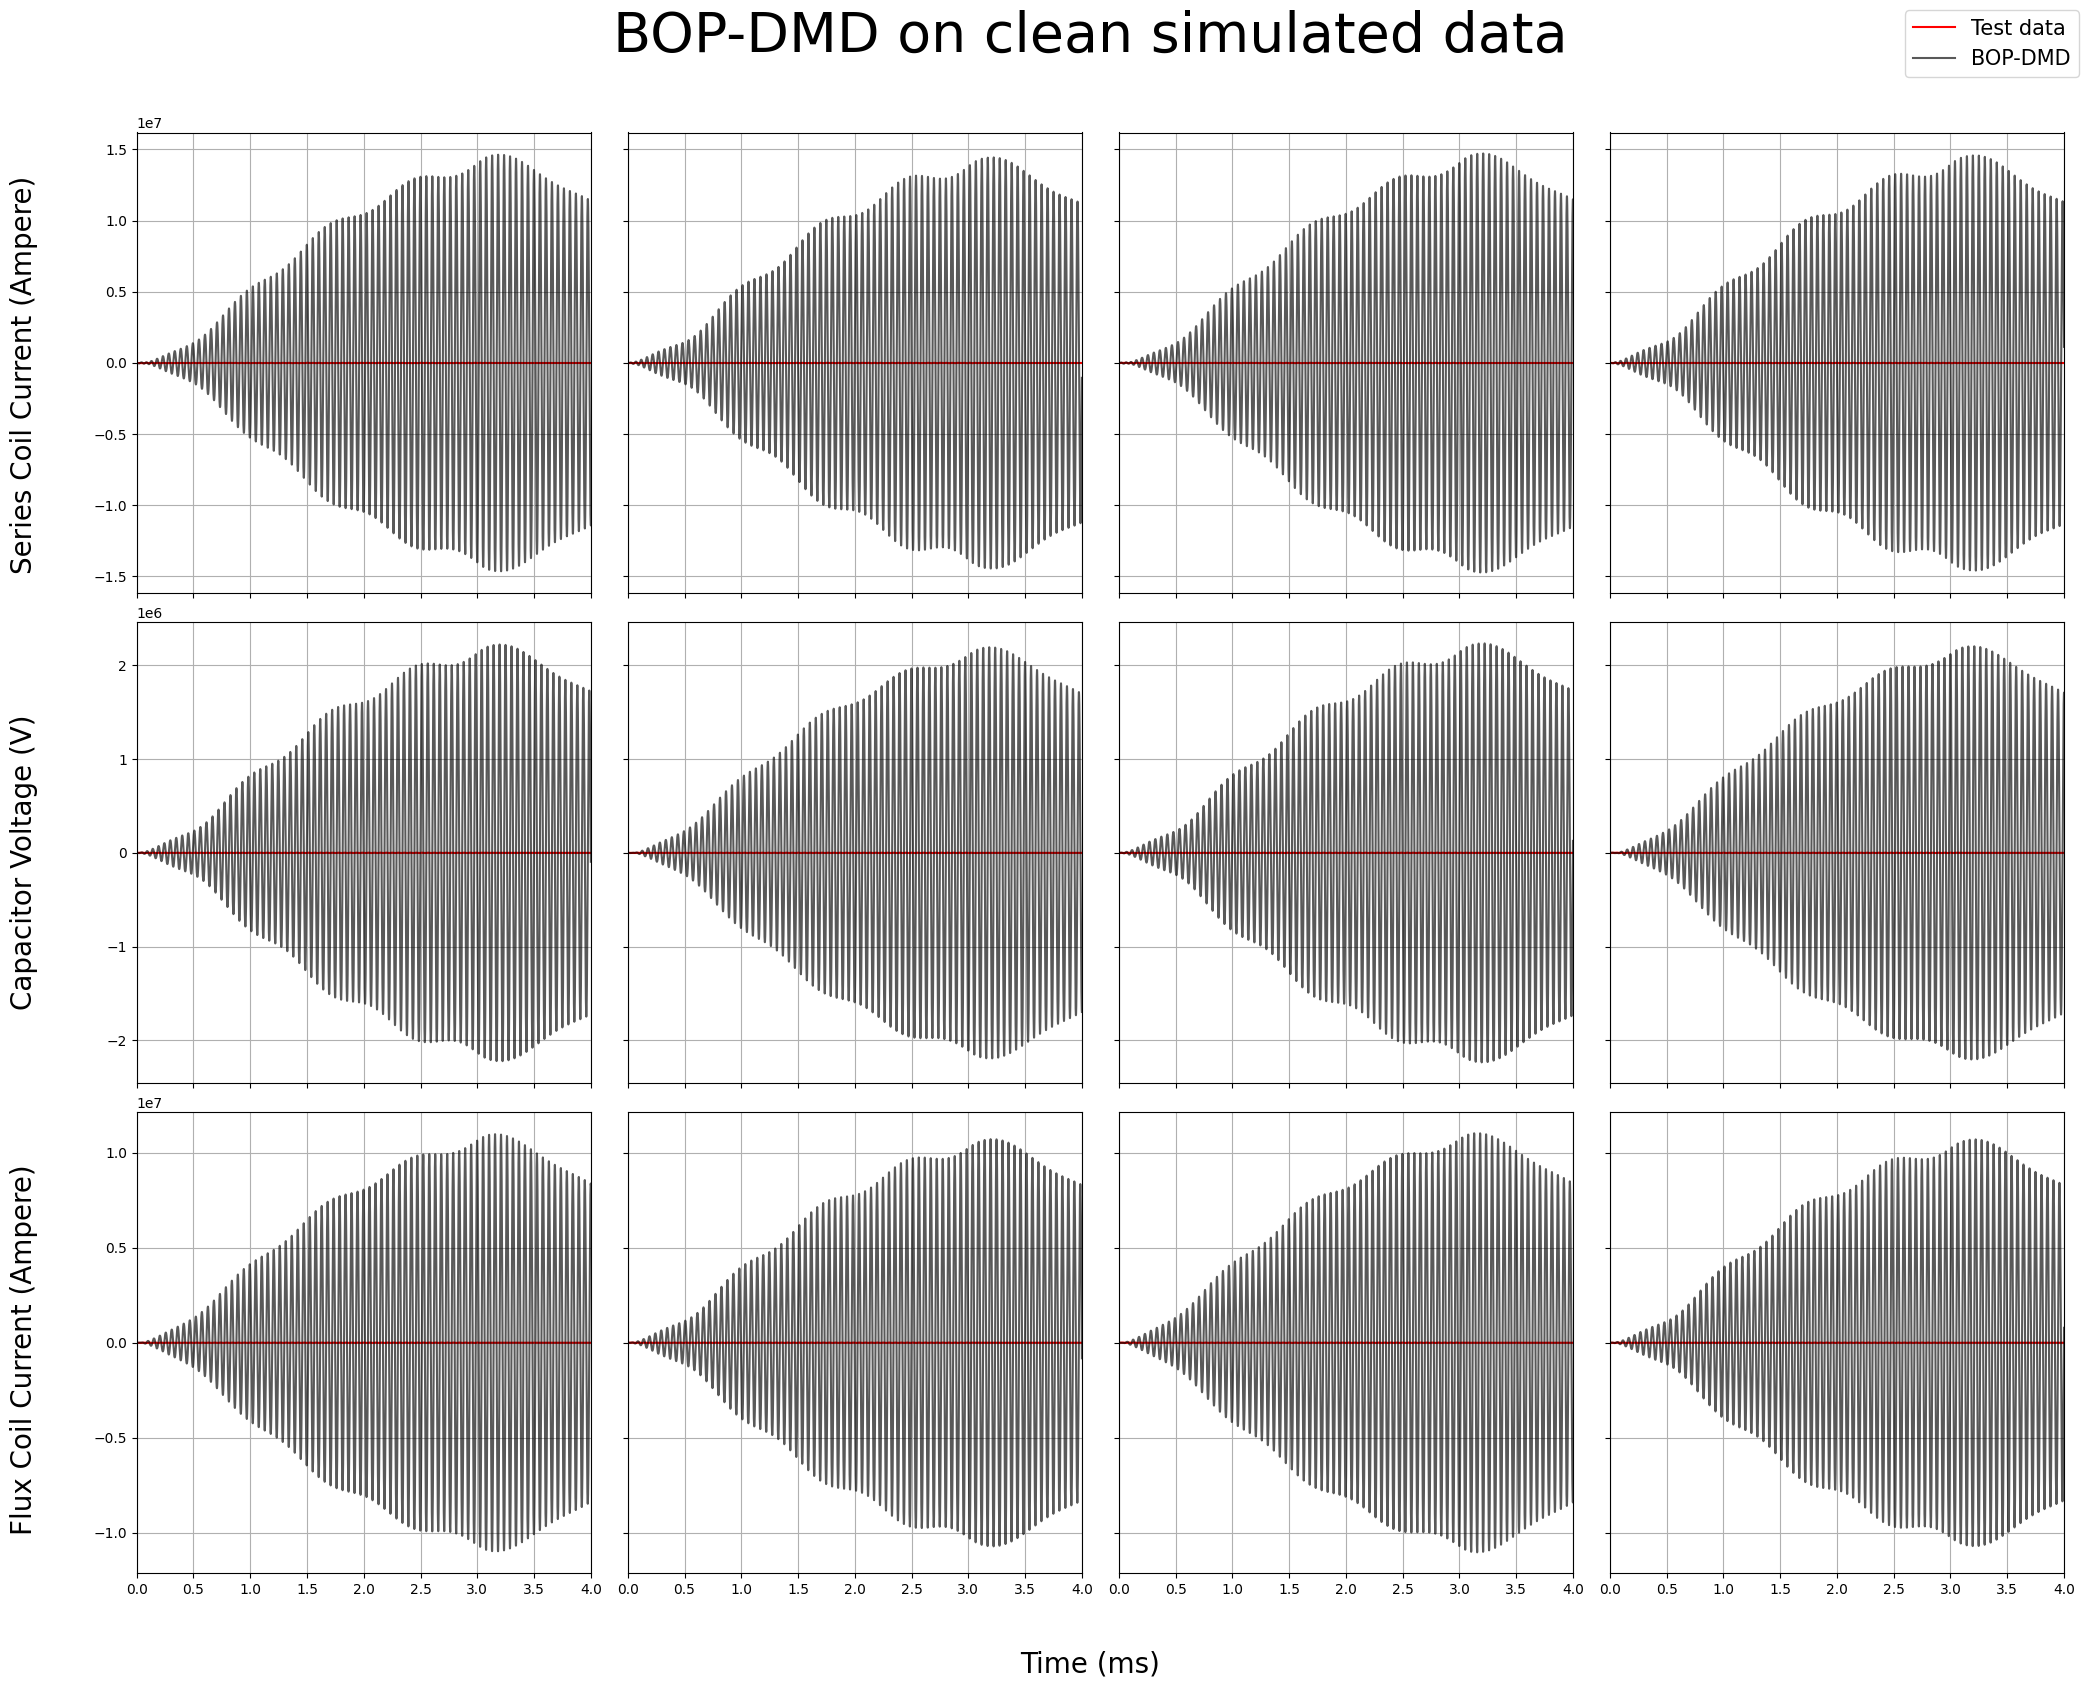

In [13]:
Atilde_vacuum_list = []
bop_vacuum_obj_list = []
xout_vacuum_list = []
skip = 10
for i in [11]:
    [Atilde, bop_obj, xout] = bopdmd_train_test(
        svd_rank=i + 1,
        num_trials=1,
        training_set=xout_vacuum.real[::skip, :].T,  # this is the 'impulse' response from above
        training_voltage=inputs[::skip, :],
        test_voltage=inputs,
        train_time=time[::skip],
        test_time=time,
        Btilde=B,
        C=C,
        D=D,
        return_training_fit=False,
        conjugate_bool=True, 
        stable_bool=True,
        noise_level=0,
        evaluate = True
    )
    Atilde_vacuum_list.append(Atilde)
    bop_vacuum_obj_list.append(bop_obj)
    xout_vacuum_list.append(xout)
    
# Visualize the performance of the BOP-DMD reconstruction on test data
num = 0
make_graph(
    [xout_vacuum, xout_vacuum_list[num]],
    'BOP-DMD on clean simulated data',
    ['Test data', 'BOP-DMD'],
    impulse=False,
    time=time
)

#### This doesn't work because BOPDMD doesn't know about the BU matrix in $\dot{X} = AX + BU$. But there is no issue using an initial condition from a real vacuum discharge & trying out the plasma model -- the only issue we will encounter is if we accidentally fit on a region where $U(t) \gg 1$.  So we will try to be careful to only fit where $U(t)\approx 0 $.

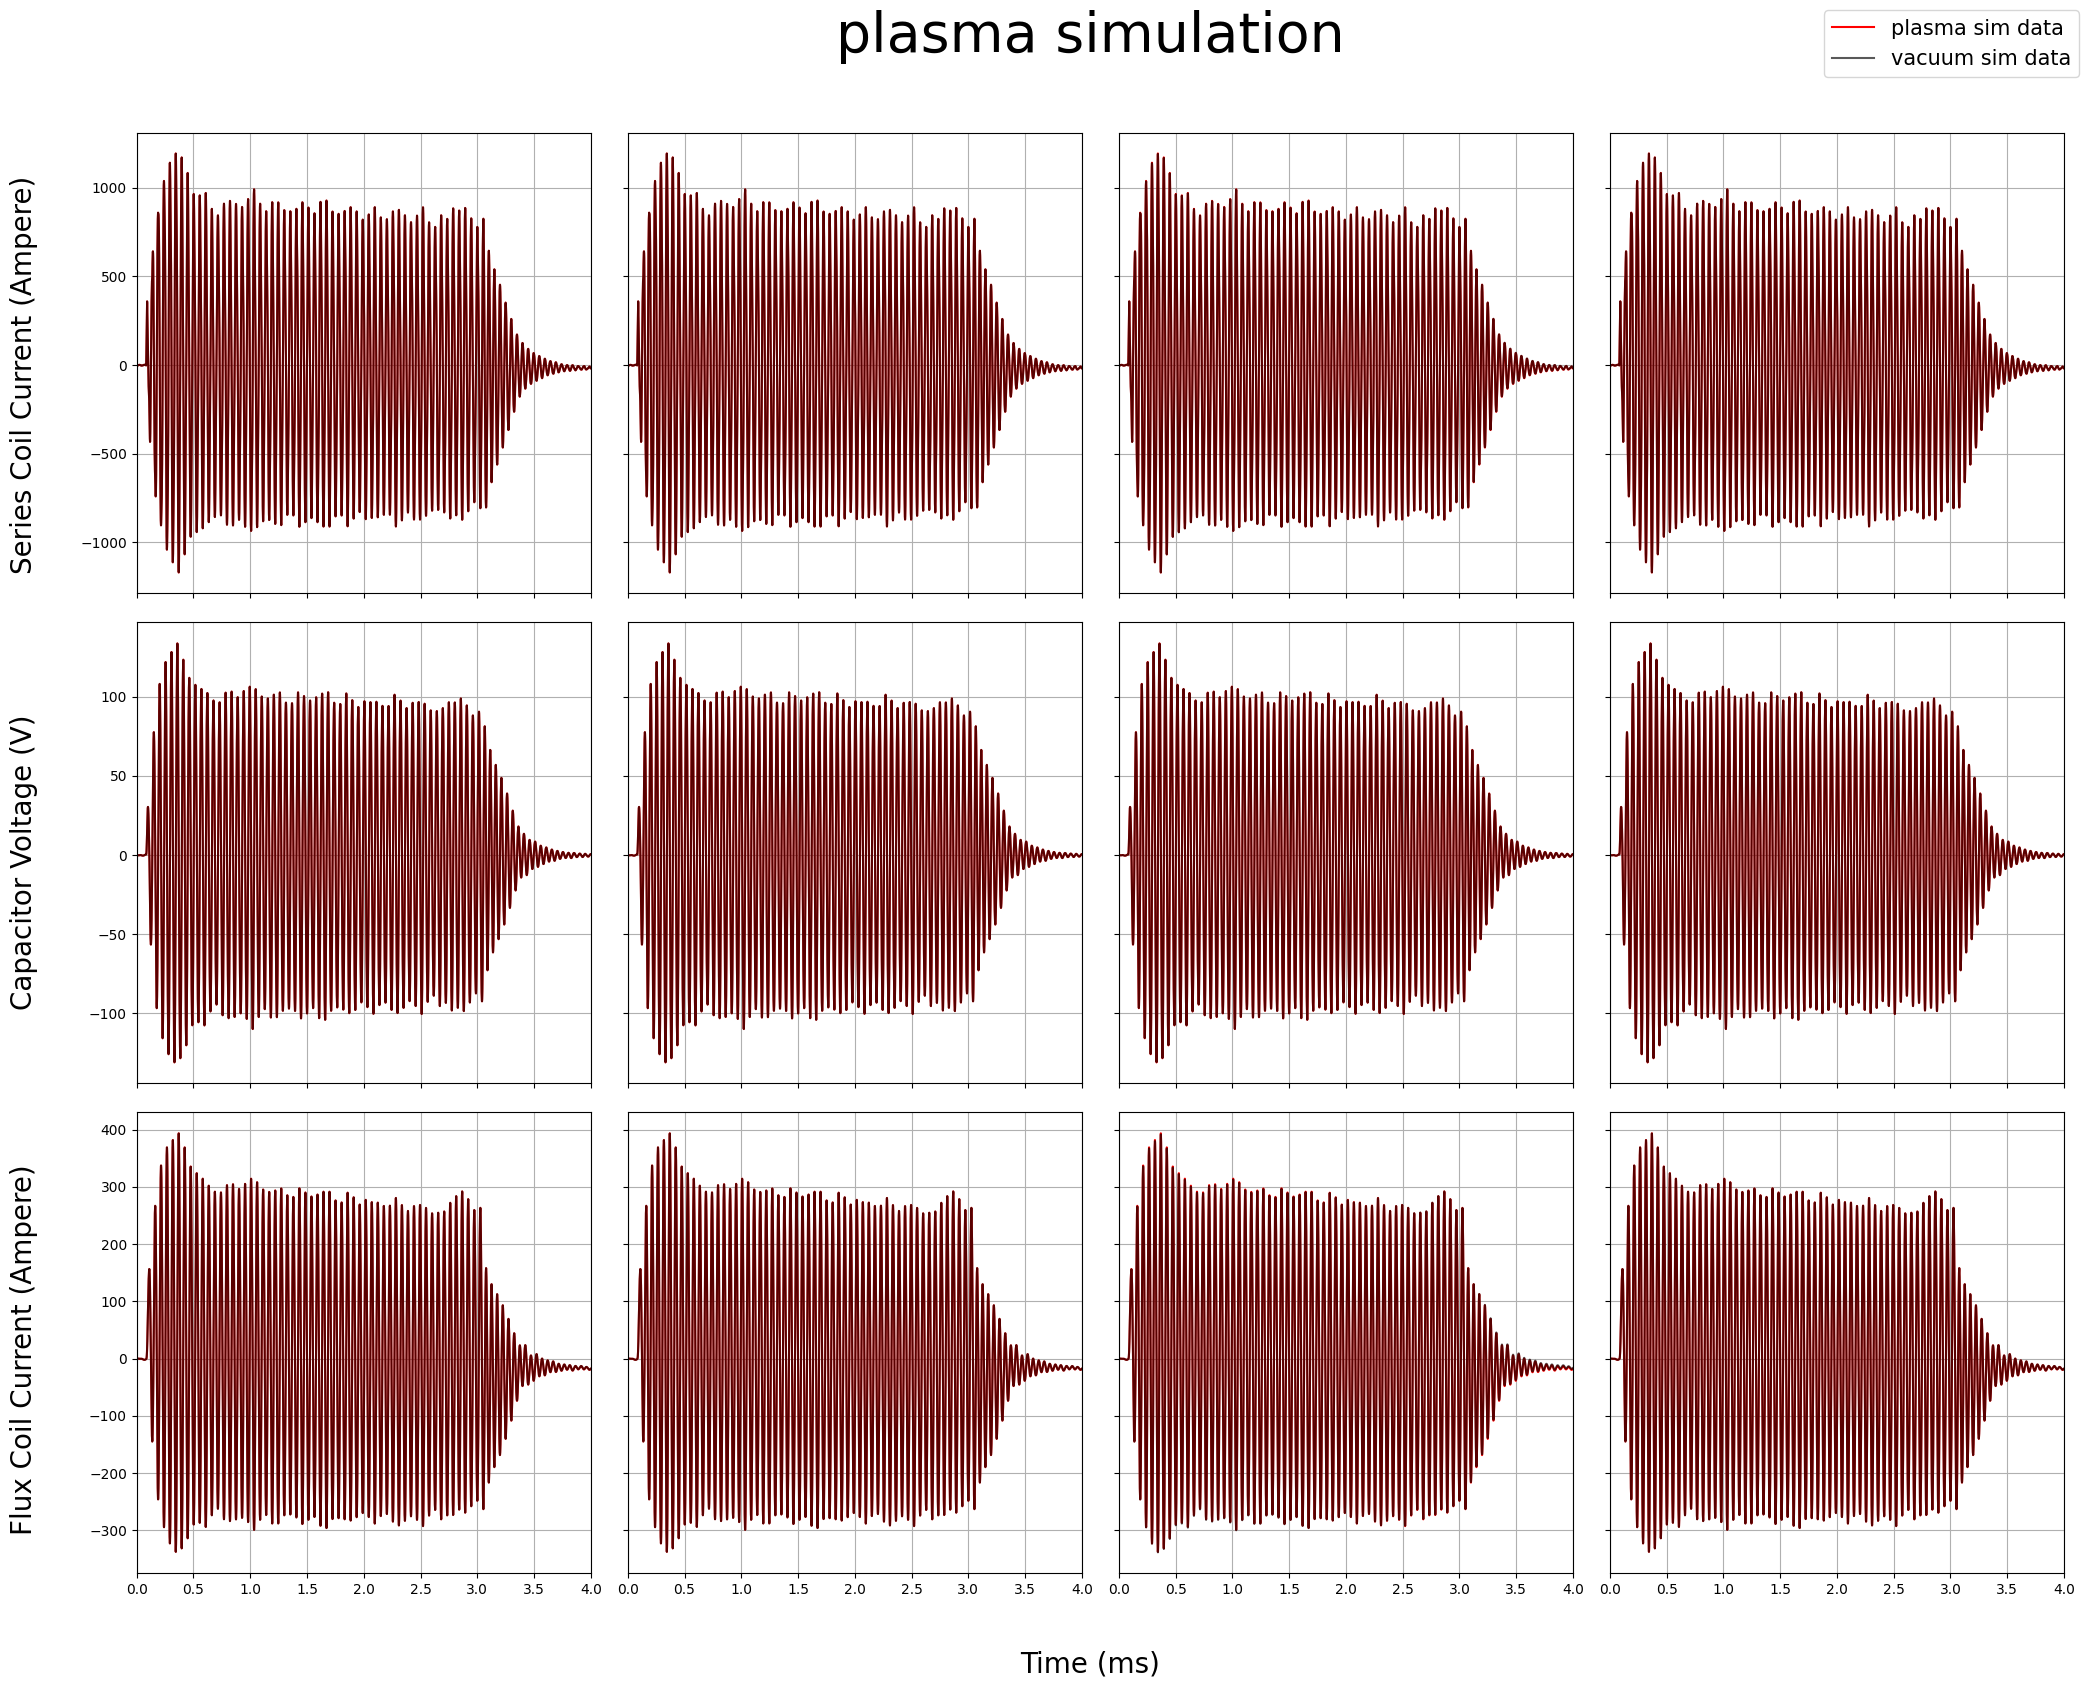

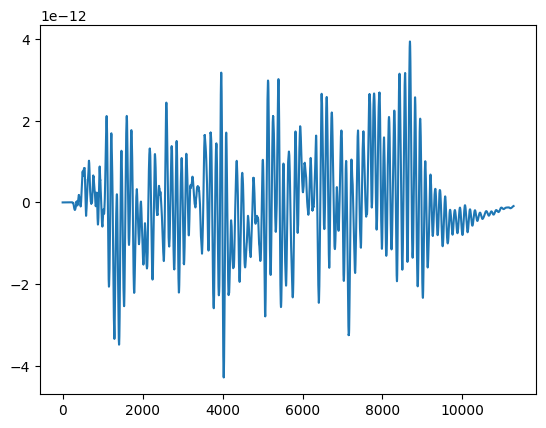

In [14]:
# This is the analytic vacuum/plasma model
# simulated with a voltage waveform from an experimental shot
# Notice time starts at index 251 to avoid negative times
experiment_times = np.linspace(experiment_time[251], 
                              experiment_time[-1], 
                              len(experiment_time) * 5)
input_voltages = np.zeros((len(experiment_times), 4))
for i in range(4):
    input_voltages[:, i] = np.interp(experiment_times, 
                           experiment_time[251::], 
                           inputs_list[2][251::, i]
                          )

tout, yout, xout_vacuum_experiment = lsim(
    (A, B, C, D), 
    input_voltages, 
    experiment_times
) 
tout, yout, xout_plasma = lsim(
    (A_plasma, B_plasma, C_plasma, D), 
    input_voltages, 
    experiment_times
) 
make_graph(
    [xout_plasma, xout_vacuum_experiment],
    'plasma simulation',
    ['plasma sim data' ,'vacuum sim data'],
    impulse=False,
    time=experiment_times
)
plt.figure()
plt.plot(xout_plasma[:, -1])

### Notice the plasma and vacuum models do the exact same evolution...
Notice also that this is dramatically down-sampled compared to the resolution we were using earlier, although we did interpolate onto a finer time base using "experimental_times".

### Okay let's try fitting BOPDMD on the simulated plasma model now.
There should be no new issue -- it's basically the same as the simulated vacuum model. The only thing we need to be careful of is that we fit the data when $U \approx 0$ because BOPDMD doesn't know how to handle the U matrix.

In [15]:
Atilde_plasma_list = []
bop_plasma_obj_list = []
xout_plasma_list = []
skip = 1
# Now truncate off the time when the voltages are substantially nonzero
# since we need U ~ 0 for a good fit (BOPDMD doesnt have the BU matrix)
trunc = 8600
for i in [3]:
    [Atilde, bop_obj, xout] = bopdmd_train_test(
        svd_rank=i + 1,
        num_trials=1,
        training_set=xout_plasma[trunc::skip, :12].T,
        training_voltage=input_voltages[trunc::skip, :],
        test_voltage=input_voltages,
        train_time=experiment_times[trunc::skip],
        test_time=experiment_times,
        Btilde=B,  #np.vstack((B, np.zeros((1, 4)))),
        C=C,  #np.hstack((C, np.zeros((4, 1)))),
        D=D,
        return_training_fit=False,
        conjugate_bool=True, 
        stable_bool=True,
        noise_level=0,
        evaluate=True
    )
    Atilde_plasma_list.append(Atilde)
    bop_plasma_obj_list.append(bop_obj)
    xout_plasma_list.append(xout)

/Users/alankaptanoglu/anaconda3/envs/pysindy_docs/lib/python3.9/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 3.91887901449567e+16. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


## Simulate plasma model with experimental waveform and fit BOP model to that. Does really well, however this is only with 3 modes

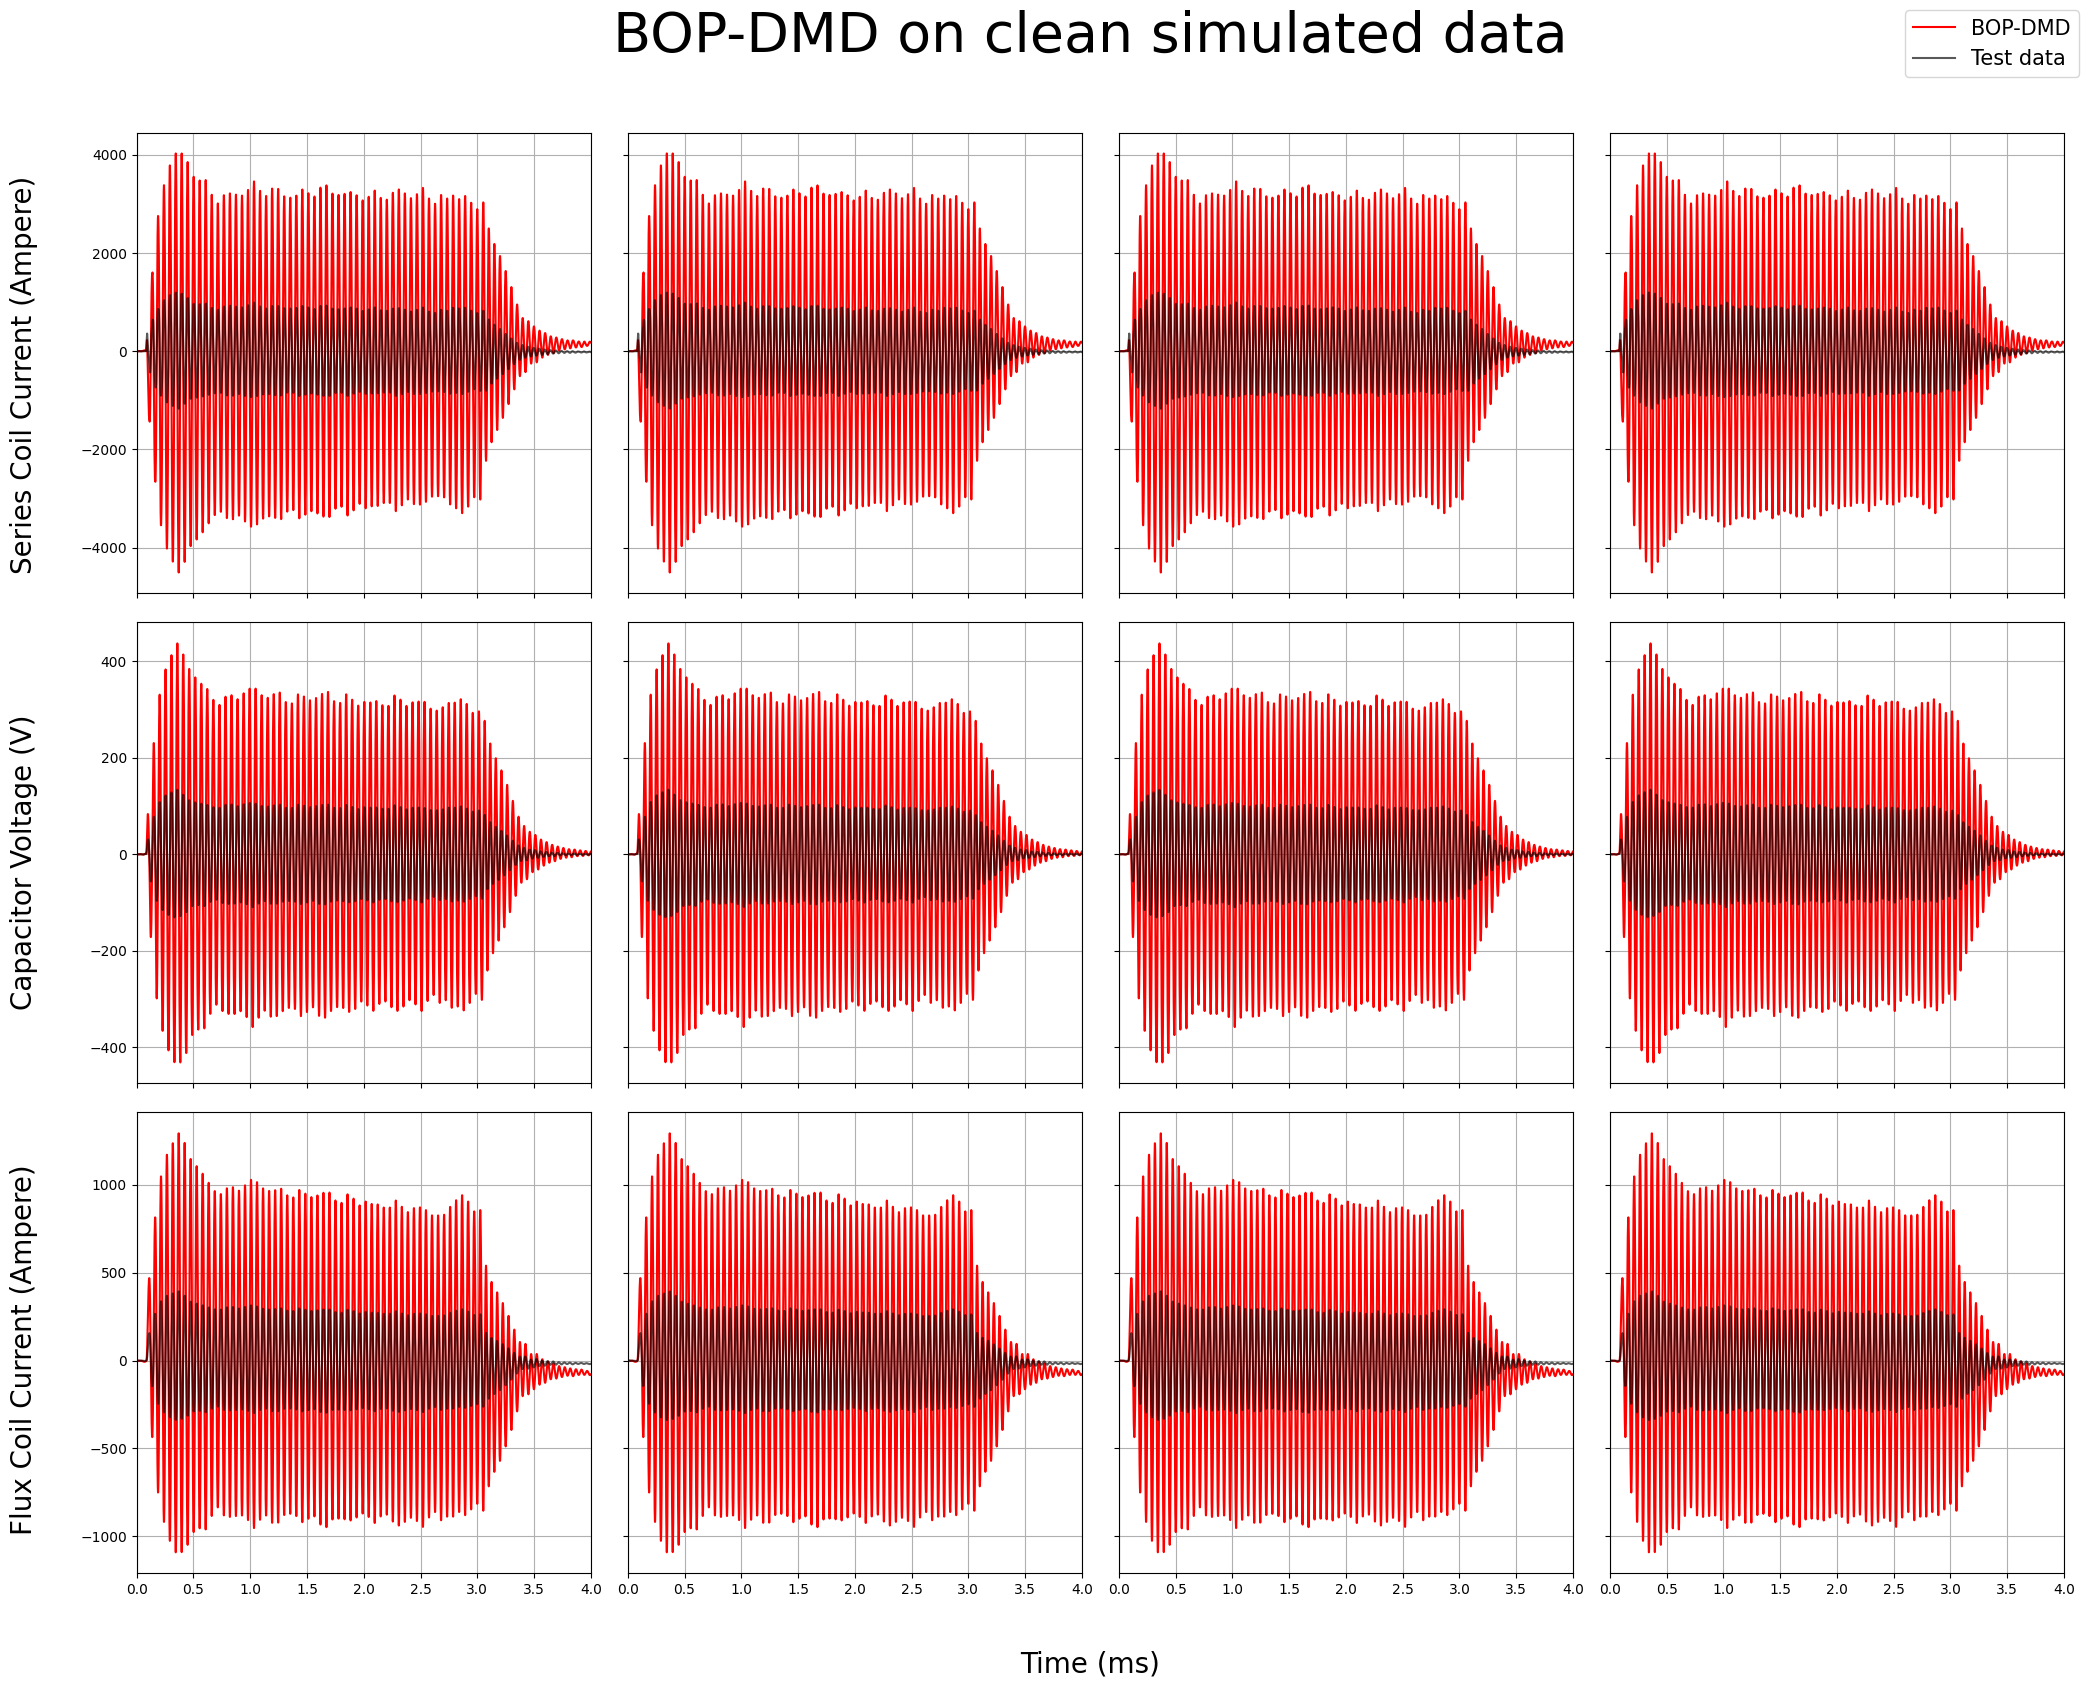

In [16]:
make_graph(
    [xout_plasma_list[-1], xout_plasma],
    'BOP-DMD on clean simulated data',
    ['BOP-DMD', 'Test data'],
    impulse=False,
    time=experiment_times
)

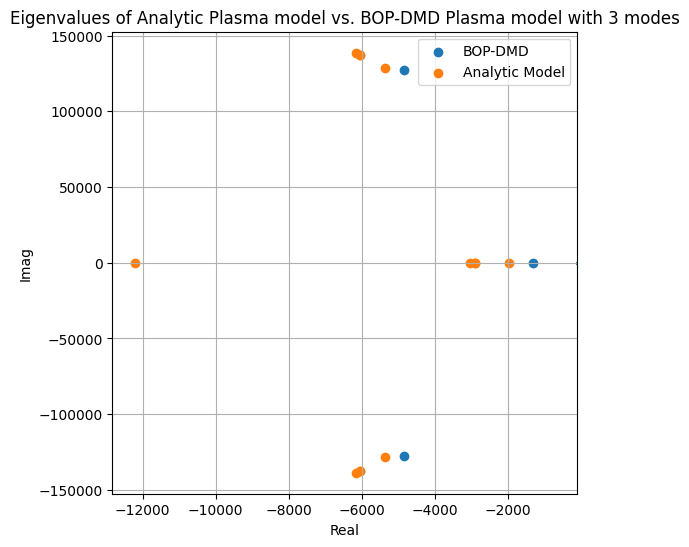

In [17]:
plt.figure(figsize=(6, 6))
plt.title('Eigenvalues of Analytic Plasma model vs. BOP-DMD Plasma model with 3 modes')
plt.scatter(np.linalg.eigvals(Atilde_plasma_list[-1]).real,
            np.linalg.eigvals(Atilde_plasma_list[-1]).imag)
plt.scatter(np.linalg.eigvals(A_plasma).real,np.linalg.eigvals(A_plasma).imag)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.xlim(right = -100)
plt.legend(['BOP-DMD','Analytic Model'])
plt.grid()
plt.show()

/var/folders/kk/vfzyhbbx0rv1p32zd7s42s180000gn/T/ipykernel_19848/1914496342.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


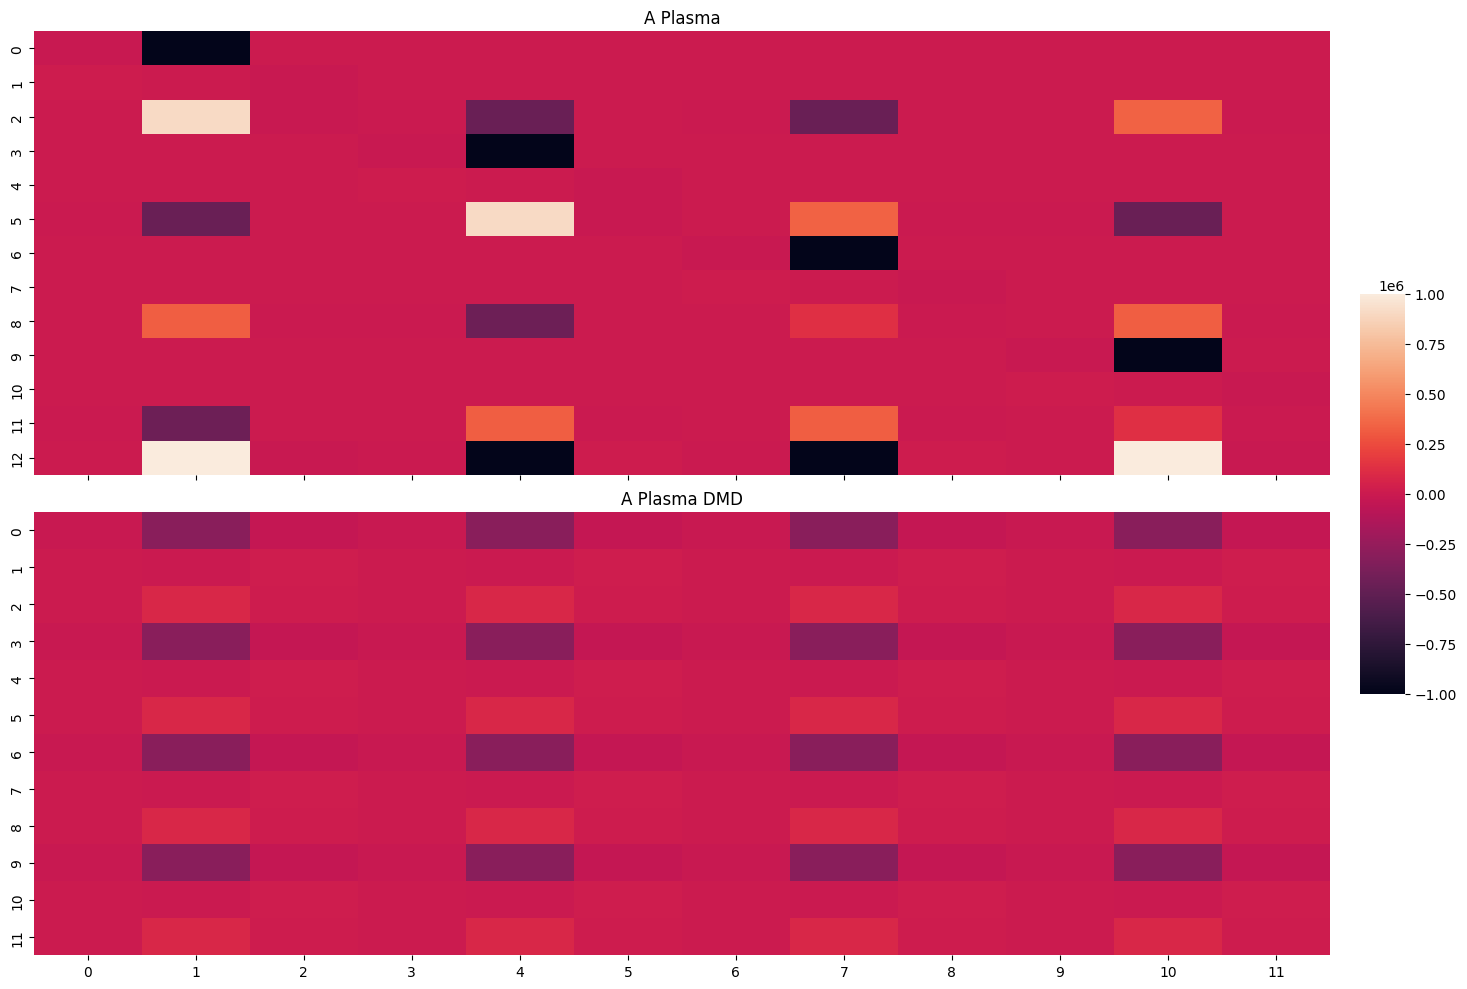

In [18]:
A_aug = np.zeros((13, 13))
A_aug[:12, :12] = A
vals = [A_plasma, Atilde_plasma_list[-1].real]
fig, axn = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
titles = ['A Plasma', 'A Plasma DMD']
for i, ax in enumerate(axn.flat):
    sns.heatmap(data=vals[i], 
                ax=ax,
                cbar=i == 0,
                cbar_ax=None if i else cbar_ax,vmin = -1e6, vmax = 1e6)
    ax.title.set_text(titles[i])
    sns.color_palette("Dark2", as_cmap=True)
fig.tight_layout(rect=[0, 0, .9, 1])